In [39]:
from scipy.sparse import csr_matrix
from math import ceil, floor

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
jan_data = pd.read_csv("yellow_tripdata_2016-01.csv")
jan_data

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2016-01-01 00:00:00,2016-01-01 00:00:00,2,1.10,-73.990372,40.734695,1,N,-73.981842,40.732407,2,7.5,0.5,0.5,0.00,0.00,0.3,8.80
1,2,2016-01-01 00:00:00,2016-01-01 00:00:00,5,4.90,-73.980782,40.729912,1,N,-73.944473,40.716679,1,18.0,0.5,0.5,0.00,0.00,0.3,19.30
2,2,2016-01-01 00:00:00,2016-01-01 00:00:00,1,10.54,-73.984550,40.679565,1,N,-73.950272,40.788925,1,33.0,0.5,0.5,0.00,0.00,0.3,34.30
3,2,2016-01-01 00:00:00,2016-01-01 00:00:00,1,4.75,-73.993469,40.718990,1,N,-73.962242,40.657333,2,16.5,0.0,0.5,0.00,0.00,0.3,17.30
4,2,2016-01-01 00:00:00,2016-01-01 00:00:00,3,1.76,-73.960625,40.781330,1,N,-73.977264,40.758514,2,8.0,0.0,0.5,0.00,0.00,0.3,8.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10906853,2,2016-01-31 23:30:32,2016-01-31 23:38:18,1,2.20,-74.003578,40.751011,1,N,-73.982651,40.767509,2,8.5,0.5,0.5,0.00,0.00,0.3,9.80
10906854,1,2016-01-05 00:15:55,2016-01-05 00:16:06,1,0.00,-73.945488,40.751530,1,N,-73.945457,40.751530,2,2.5,0.5,0.5,0.00,0.00,0.3,3.80
10906855,1,2016-01-05 06:12:46,2016-03-19 20:45:50,3,1.40,-73.994240,40.766586,1,N,-73.984428,40.753922,2,7.5,0.5,0.5,0.00,0.00,0.3,8.80
10906856,1,2016-01-05 06:21:44,2016-03-28 12:54:26,1,2.10,-73.948067,40.776531,1,N,-73.978188,40.777435,1,11.5,0.0,0.5,2.45,0.00,0.3,14.75


In [3]:
jan_data.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'RatecodeID', 'store_and_fwd_flag',
       'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount',
       'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount'],
      dtype='object')

In [4]:
# filter the data by latitude, longitude
min_lon, max_lon = -74.255864, -73.70144
min_lat, max_lat = 40.495831, 40.915669

data = jan_data[(jan_data["pickup_latitude"] >= min_lat) & (jan_data["pickup_latitude"] <= max_lat) &
                (jan_data["pickup_longitude"] >= min_lon) & (jan_data["pickup_longitude"] <= max_lon) &
                (jan_data["dropoff_latitude"] >= min_lat) & (jan_data["dropoff_latitude"] <= max_lat) &
                (jan_data["dropoff_longitude"] >= min_lon) & (jan_data["dropoff_longitude"] <= max_lon)]

In [5]:
# filter data by fare_amount
print("99.9% of the fare amounts are less than: ", data["fare_amount"].quantile(q=0.999), "dollars")
data = data[(data["fare_amount"] > 0) & (data["fare_amount"] < 100)]

99.9% of the fare amounts are less than:  72.0 dollars


In [6]:
# filter data by trip_distance
print("99.9% of the rip distances are less than: ", data["trip_distance"].quantile(q=0.999), "miles")
data = data[(data["trip_distance"] > 0) & (data["trip_distance"] < 24)]

99.9% of the rip distances are less than:  22.9 miles


In [7]:
data['tpep_pickup_datetime']= pd.to_datetime(data['tpep_pickup_datetime'])
data['tpep_dropoff_datetime']= pd.to_datetime(data['tpep_dropoff_datetime']) 

data["trip_duration"] = (data["tpep_dropoff_datetime"] - data["tpep_pickup_datetime"]).dt.total_seconds()
print("99.9% of the trip duratins are less than: ", data["trip_duration"].quantile(q=0.999), "seconds")
data = data[(data["trip_duration"] > 0) & (data["trip_duration"] < 24*3600) ]

99.9% of the trip duratins are less than:  85455.0 seconds


In [8]:
data["speed"] = data["trip_distance"] / (data["trip_duration"] / 3600)
print("99.9% of the trip speeds are less than: ", data["speed"].quantile(q=0.999), "mph")
data = data[(data["speed"] > 0) & (data["speed"] < 100)]

99.9% of the trip speeds are less than:  48.07935542394602 mph


In [9]:
data

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,...,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip_duration,speed
5,2,2016-01-01 00:00:00,2016-01-01 00:18:30,2,5.52,-73.980118,40.743050,1,N,-73.913490,...,2,19.0,0.5,0.5,0.00,0.0,0.3,20.30,1110.0,17.902703
6,2,2016-01-01 00:00:00,2016-01-01 00:26:45,2,7.45,-73.994057,40.719990,1,N,-73.966362,...,2,26.0,0.5,0.5,0.00,0.0,0.3,27.30,1605.0,16.710280
7,1,2016-01-01 00:00:01,2016-01-01 00:11:55,1,1.20,-73.979424,40.744614,1,N,-73.992035,...,2,9.0,0.5,0.5,0.00,0.0,0.3,10.30,714.0,6.050420
8,1,2016-01-01 00:00:02,2016-01-01 00:11:14,1,6.00,-73.947151,40.791046,1,N,-73.920769,...,2,18.0,0.5,0.5,0.00,0.0,0.3,19.30,672.0,32.142857
9,2,2016-01-01 00:00:02,2016-01-01 00:11:08,1,3.21,-73.998344,40.723896,1,N,-73.995850,...,2,11.5,0.5,0.5,0.00,0.0,0.3,12.80,666.0,17.351351
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10906849,2,2016-01-31 21:28:59,2016-01-31 22:01:58,1,7.83,-74.002953,40.750481,1,N,-73.958153,...,1,29.0,0.5,0.5,5.00,0.0,0.3,35.30,1979.0,14.243557
10906850,2,2016-01-31 22:36:41,2016-01-31 22:45:04,1,2.50,-74.009277,40.717049,1,N,-73.994637,...,1,9.5,0.5,0.5,2.16,0.0,0.3,12.96,503.0,17.892644
10906851,2,2016-01-31 22:53:00,2016-01-31 22:59:37,1,1.68,-74.003578,40.750751,1,N,-74.002159,...,1,7.0,0.5,0.5,1.00,0.0,0.3,9.30,397.0,15.234257
10906852,2,2016-01-31 23:00:11,2016-01-31 23:12:08,1,2.65,-74.002159,40.734852,1,N,-73.999680,...,1,11.0,0.5,0.5,1.00,0.0,0.3,13.30,717.0,13.305439


In [10]:
def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = R = 6371.0 * c # 6371 radius of the earth in km
    return km * 1000


In [11]:
grid_side_length = 200  # 200m
time_interval_length = 20  # 20 min

width = haversine_np(min_lon, min_lat, max_lon, min_lat)
height = haversine_np(min_lon, min_lat, min_lon, max_lat)

print(width, height)

H = ceil(height / grid_side_length)
W = ceil(width / grid_side_length)

bottom_left_lon = np.array([min_lon] * data.shape[0])
bottom_left_lat = np.array([min_lat] * data.shape[0])
min_timestamp = pd.Timestamp('2016-01-01 00:00:00')


def set_grid_index(data):
  src_x = haversine_np(bottom_left_lon, bottom_left_lat, data["pickup_longitude"], bottom_left_lat)
  src_y = haversine_np(bottom_left_lon, bottom_left_lat, bottom_left_lon, data["pickup_latitude"])

  src_x = np.floor(src_x / grid_side_length)
  src_y = np.floor(src_y / grid_side_length)
  data["pickup_grid"] = src_y * W + src_x

  dest_x = haversine_np(bottom_left_lon, bottom_left_lat, data["dropoff_longitude"], bottom_left_lat)
  dest_y = haversine_np(bottom_left_lon, bottom_left_lat, bottom_left_lon, data["dropoff_latitude"])
  dest_x = np.floor(dest_x / grid_side_length)
  dest_y = np.floor(dest_y / grid_side_length)
  data["dropoff_grid"] = dest_y * W + dest_x


def set_timeinterval_index(data):
  time_delta_minutes = (data["tpep_pickup_datetime"] - min_timestamp).dt.total_seconds() / 60
  data["pickup_timeinterval_index"] = np.floor(time_delta_minutes / time_interval_length)

46881.206807883544 46683.85561259839


In [12]:
set_grid_index(data)
set_timeinterval_index(data)
data = data.astype({'pickup_grid': 'int32', 'dropoff_grid': 'int32', 'pickup_timeinterval_index': 'int32'})
data

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,...,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip_duration,speed,pickup_grid,dropoff_grid,pickup_timeinterval_index
5,2,2016-01-01 00:00:00,2016-01-01 00:18:30,2,5.52,-73.980118,40.743050,1,N,-73.913490,...,0.5,0.00,0.0,0.3,20.30,1110.0,17.902703,32311,34924,0
6,2,2016-01-01 00:00:00,2016-01-01 00:26:45,2,7.45,-73.994057,40.719990,1,N,-73.966362,...,0.5,0.00,0.0,0.3,27.30,1605.0,16.710280,29250,38427,0
7,1,2016-01-01 00:00:01,2016-01-01 00:11:55,1,1.20,-73.979424,40.744614,1,N,-73.992035,...,0.5,0.00,0.0,0.3,10.30,714.0,6.050420,32546,33716,0
8,1,2016-01-01 00:00:02,2016-01-01 00:11:14,1,6.00,-73.947151,40.791046,1,N,-73.920769,...,0.5,0.00,0.0,0.3,19.30,672.0,32.142857,38670,48316,0
9,2,2016-01-01 00:00:02,2016-01-01 00:11:08,1,3.21,-73.998344,40.723896,1,N,-73.995850,...,0.5,0.00,0.0,0.3,12.80,666.0,17.351351,29718,25254,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10906849,2,2016-01-31 21:28:59,2016-01-31 22:01:58,1,7.83,-74.002953,40.750481,1,N,-73.958153,...,0.5,5.00,0.0,0.3,35.30,1979.0,14.243557,33241,21040,2224
10906850,2,2016-01-31 22:36:41,2016-01-31 22:45:04,1,2.50,-74.009277,40.717049,1,N,-73.994637,...,0.5,2.16,0.0,0.3,12.96,503.0,17.892644,28774,33245,2227
10906851,2,2016-01-31 22:53:00,2016-01-31 22:59:37,1,1.68,-74.003578,40.750751,1,N,-74.002159,...,0.5,1.00,0.0,0.3,9.30,397.0,15.234257,33241,31127,2228
10906852,2,2016-01-31 23:00:11,2016-01-31 23:12:08,1,2.65,-74.002159,40.734852,1,N,-73.999680,...,0.5,1.00,0.0,0.3,13.30,717.0,13.305439,31127,34653,2229


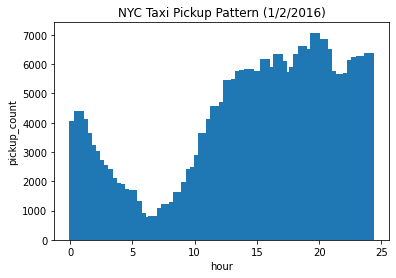

In [60]:
pickup_data = data.groupby('pickup_timeinterval_index').size().reset_index(name='pickup_count')
pickup_data['hour'] = pickup_data['pickup_timeinterval_index'] / 3

f = plt.figure()
plt.bar(
    pickup_data[(pickup_data['hour'] > 23) & (pickup_data['hour'] <= 47)]['hour'] - 23,
    pickup_data[(pickup_data['hour'] > 23) & (pickup_data['hour'] <= 47)]['pickup_count']
)
plt.xlabel('hour')
plt.ylabel('pickup_count')
plt.title('NYC Taxi Pickup Pattern (1/2/2016)')
f.savefig("pickups_by_hour.png", bbox_inches='tight', dpi=600)

In [61]:
!ls

cnn_assignmen	  pickups_by_hour.png  yellow_tripdata_2016-01.csv
gat		  __pycache__	       yellow_tripdata_2016-02.csv
gm_project.ipynb  scratchpad.ipynb


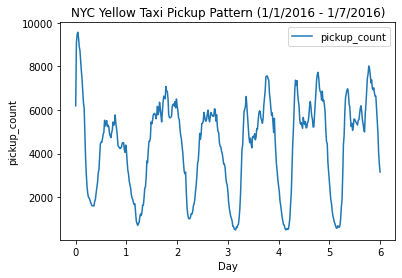

In [65]:
pickup_data['day'] = pickup_data['pickup_timeinterval_index'] / (3*24)
pl = pickup_data[pickup_data["day"] <= 6].plot(x='day', y='pickup_count')

plt.title("NYC Yellow Taxi Pickup Pattern (1/1/2016 - 1/7/2016)")
plt.ylabel('pickup_count')
plt.xlabel('Day')
# f.savefig("pickups_by_day.png", bbox_inches='tight', dpi=600)

fig = pl.get_figure()
fig.savefig('pickups_by_day.png')

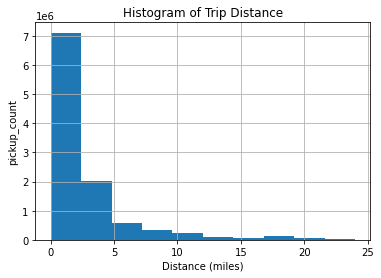

In [63]:
f = plt.figure()
distance_data = data['trip_distance'].hist()
plt.ylabel('pickup_count')
plt.xlabel('Distance (miles)')
plt.title('Histogram of Trip Distance')
f.savefig("trip_distance_histogram.png", bbox_inches='tight', dpi=600)

In [59]:
nets = {}
graph_data = data[["pickup_grid", "dropoff_grid", "pickup_timeinterval_index"]]

for t in range (max(graph_data["pickup_timeinterval_index"])):
    t_graph_data = graph_data[graph_data["pickup_timeinterval_index"] == t]
    src, dest = t_graph_data['pickup_grid'], t_graph_data['dropoff_grid']
    pickup_counts = t_graph_data.groupby('pickup_grid').size().to_dict()
    nets[t] = {
        't': t,
        'mat': csr_matrix((np.ones(len(src), dtype=np.bool_), (src, dest))),
        'pickup_count': pickup_counts
    }

len(nets)

2231

In [253]:
nets[0]['mat'].toarray()

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])